In [13]:
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.isotonic import IsotonicRegression

In [14]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


def save_hist(data, title, xlabel, filename, bins=30, kde=False):
    plt.figure()
    sns.histplot(data, bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()


def save_scatter(x, y, title, xlabel, ylabel, filename, alpha=0.3):
    plt.figure()
    plt.scatter(x, y, alpha=alpha)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()    
    plt.close()


Loading data...
Train: 5000, Test: 3638


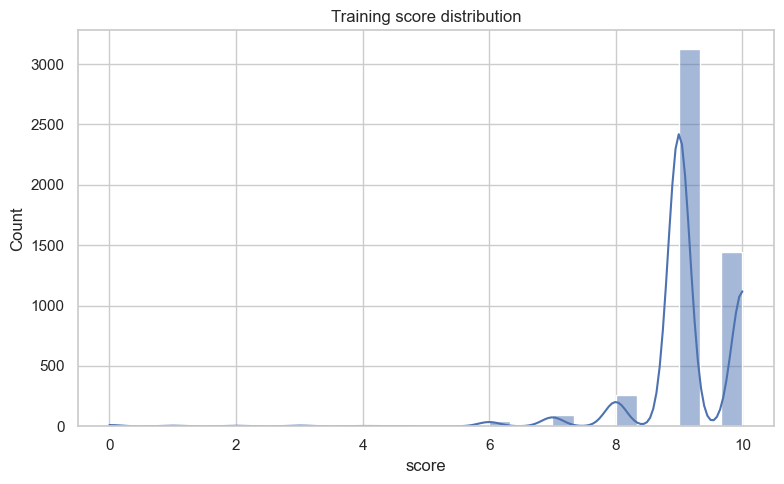

In [15]:
print("Loading data...")
with open('train_data.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open('test_data.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)
with open('metric_names.json', 'r', encoding='utf-8') as f:
    metric_names = json.load(f)

print(f"Train: {len(train_data)}, Test: {len(test_data)}")

# Visualize target distribution
train_scores = np.array([float(item['score']) for item in train_data])
save_hist(
    train_scores,
    title="Training score distribution",
    xlabel="score",
    filename="viz_train_scores_hist.png",
    bins=30,
    kde=True
)


In [17]:
metric_embeddings = np.load('metric_name_embeddings.npy')
metric_to_idx = {name: idx for idx, name in enumerate(metric_names)}
metric_emb_dict = {name: metric_embeddings[idx] for name, idx in metric_to_idx.items()}

# Visualize norms of metric embeddings
metric_norms = np.linalg.norm(metric_embeddings, axis=1)



Initializing text model...


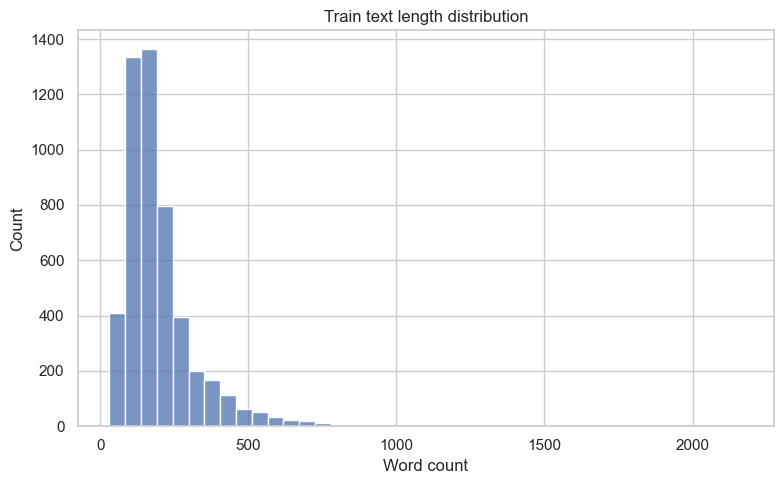

In [18]:
print("\nInitializing text model...")
text_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')


def create_combined_text(item):
    return f"{item.get('system_prompt', '')} [SEP] {item.get('user_prompt', '')} [SEP] {item.get('response', '')}"


train_texts = [create_combined_text(item) for item in train_data]
test_texts = [create_combined_text(item) for item in test_data]

# Visualize text length distribution
train_lengths = [len(t.split()) for t in train_texts]
save_hist(
    train_lengths,
    title="Train text length distribution",
    xlabel="Word count",
    filename="viz_train_text_lengths.png",
    bins=40,
    kde=False
)


Encoding training texts...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding test texts...


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

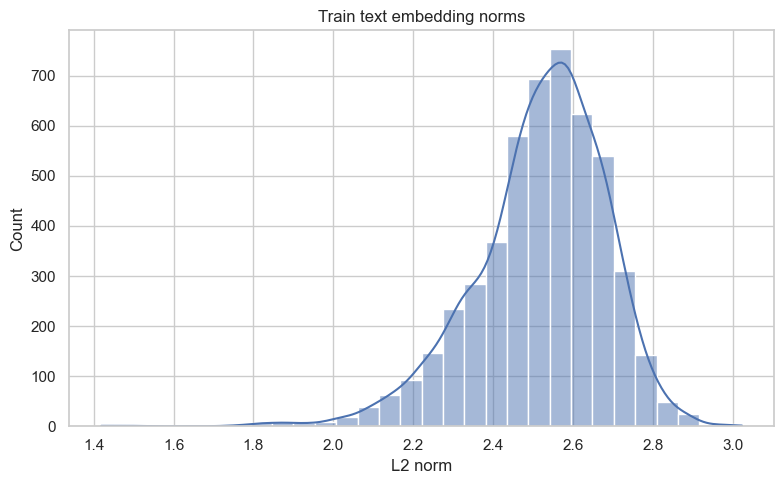

In [19]:
print("Encoding training texts...")
train_text_embeddings = text_model.encode(
    train_texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Encoding test texts...")
test_text_embeddings = text_model.encode(
    test_texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

# Visualize text embedding norms
train_text_norms = np.linalg.norm(train_text_embeddings, axis=1)
save_hist(
    train_text_norms,
    title="Train text embedding norms",
    xlabel="L2 norm",
    filename="viz_train_text_embedding_norms.png",
    bins=30,
    kde=True
)


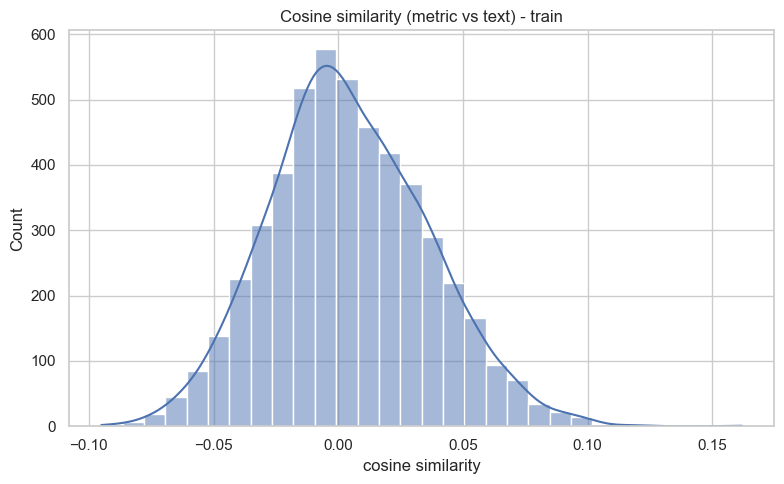

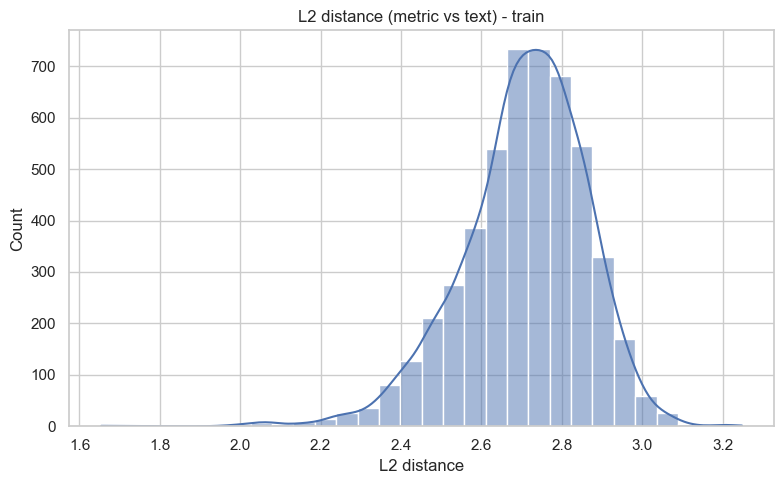

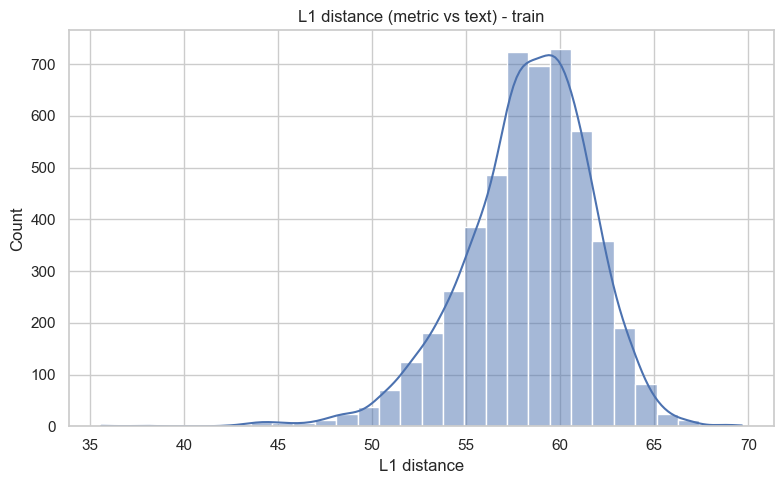

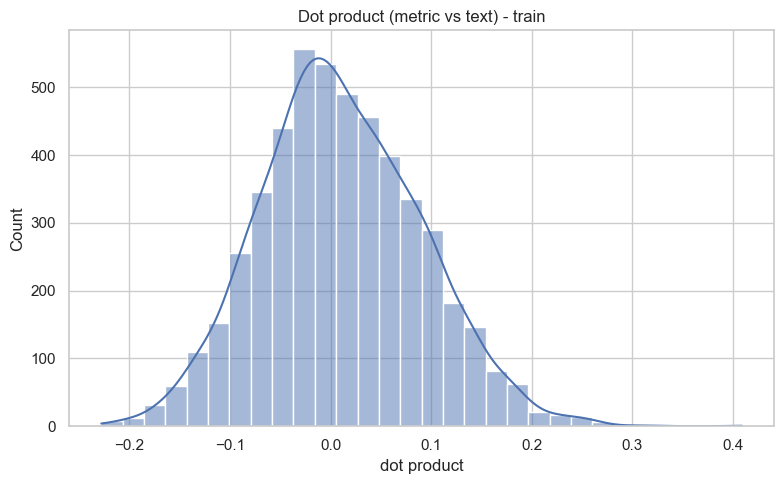

In [21]:
def create_features(data, text_embeddings, metric_emb_dict):
    """Same as before + additional distance metrics"""
    features = []
    cos_sims = []
    l2_dists = []
    l1_dists = []
    dots = []

    for i, item in enumerate(data):
        metric_name = item['metric_name']
        metric_emb = metric_emb_dict[metric_name]
        text_emb = text_embeddings[i]

        # Original features
        combined_features = np.concatenate([metric_emb, text_emb])
        interaction = metric_emb * text_emb[:len(metric_emb)]
        cosine_sim = np.dot(metric_emb, text_emb[:len(metric_emb)]) / (
            np.linalg.norm(metric_emb) * np.linalg.norm(text_emb[:len(metric_emb)]) + 1e-8
        )

        # NEW: Additional distance features
        l2_dist = np.linalg.norm(metric_emb - text_emb[:len(metric_emb)])
        l1_dist = np.sum(np.abs(metric_emb - text_emb[:len(metric_emb)]))
        dot_prod = np.dot(metric_emb, text_emb[:len(metric_emb)])

        final_features = np.concatenate([
            combined_features,
            interaction,
            [cosine_sim, l2_dist, l1_dist, dot_prod]
        ])
        features.append(final_features)

        # collect for visualization
        cos_sims.append(cosine_sim)
        l2_dists.append(l2_dist)
        l1_dists.append(l1_dist)
        dots.append(dot_prod)

    # Visualize similarity / distance distributions for this split
    save_hist(
        cos_sims,
        title="Cosine similarity (metric vs text) - train",
        xlabel="cosine similarity",
        filename="viz_cosine_similarity_train.png",
        bins=30,
        kde=True
    )
    save_hist(
        l2_dists,
        title="L2 distance (metric vs text) - train",
        xlabel="L2 distance",
        filename="viz_l2_distance_train.png",
        bins=30,
        kde=True
    )
    save_hist(
        l1_dists,
        title="L1 distance (metric vs text) - train",
        xlabel="L1 distance",
        filename="viz_l1_distance_train.png",
        bins=30,
        kde=True
    )
    save_hist(
        dots,
        title="Dot product (metric vs text) - train",
        xlabel="dot product",
        filename="viz_dot_product_train.png",
        bins=30,
        kde=True
    )

    return np.array(features)


X_train = create_features(train_data, train_text_embeddings, metric_emb_dict)


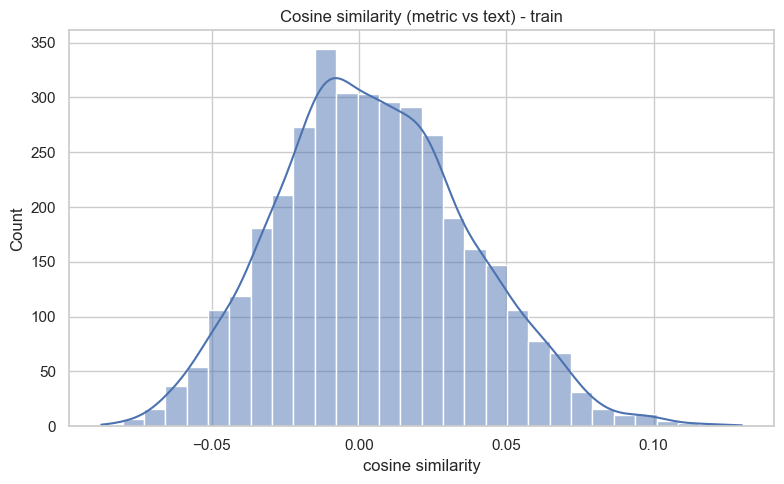

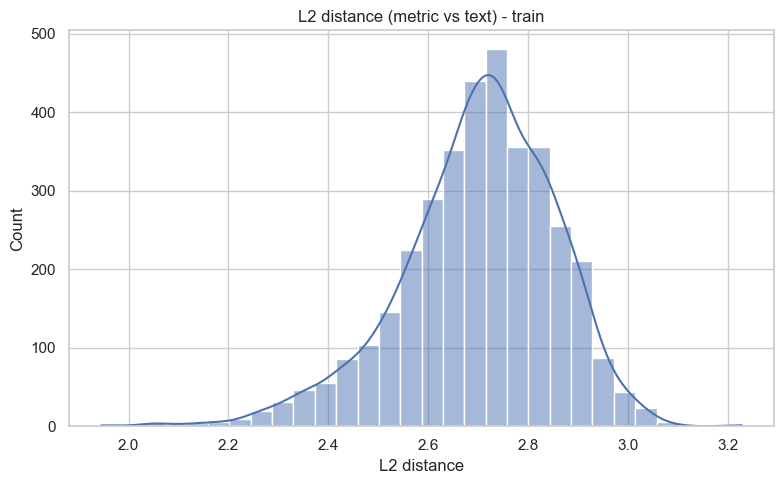

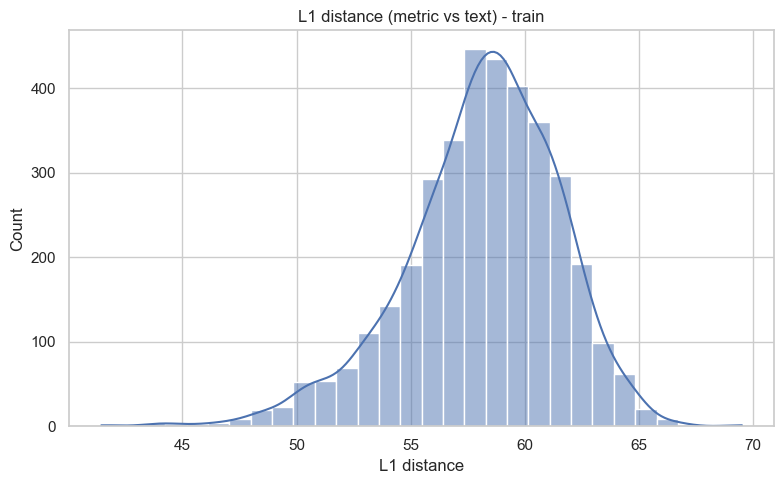

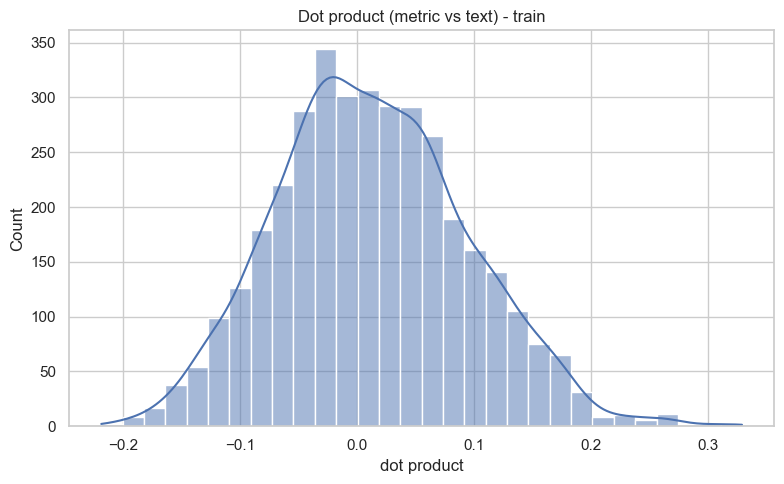

In [23]:
X_test = create_features(test_data, test_text_embeddings, metric_emb_dict)



In [24]:
y_train = train_scores

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Training target mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")

X_train shape: (5000, 2308)
X_test shape: (3638, 2308)
Training target mean: 9.12, std: 0.94


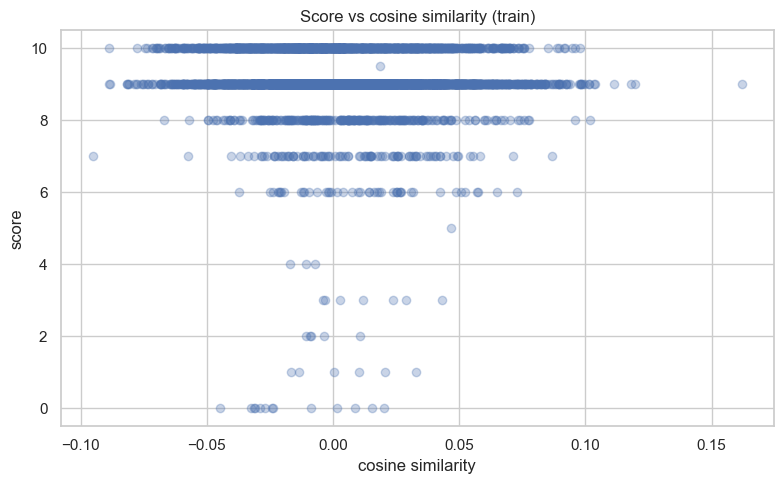

In [25]:
cos_for_scatter = []
for i, item in enumerate(train_data):
    metric_name = item['metric_name']
    metric_emb = metric_emb_dict[metric_name]
    text_emb = train_text_embeddings[i]
    cs = np.dot(metric_emb, text_emb[:len(metric_emb)]) / (
        np.linalg.norm(metric_emb) * np.linalg.norm(text_emb[:len(metric_emb)]) + 1e-8
    )
    cos_for_scatter.append(cs)

save_scatter(
    cos_for_scatter,
    y_train,
    title="Score vs cosine similarity (train)",
    xlabel="cosine similarity",
    ylabel="score",
    filename="viz_score_vs_cosine.png",
    alpha=0.3
)



Scaling features...


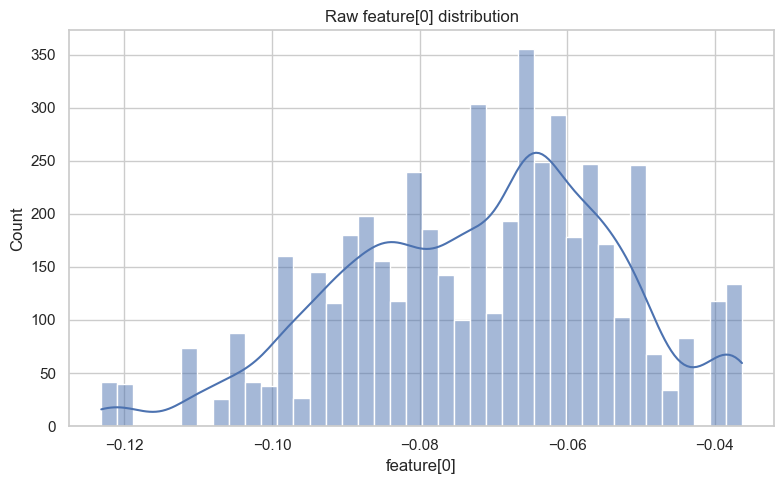

In [26]:
# ====================================================================
# STEP 4: Feature Scaling
# ====================================================================
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualize a few feature distributions before/after scaling
save_hist(
    X_train[:, 0],
    title="Raw feature[0] distribution",
    xlabel="feature[0]",
    filename="viz_feature0_raw.png",
    bins=40,
    kde=True
)

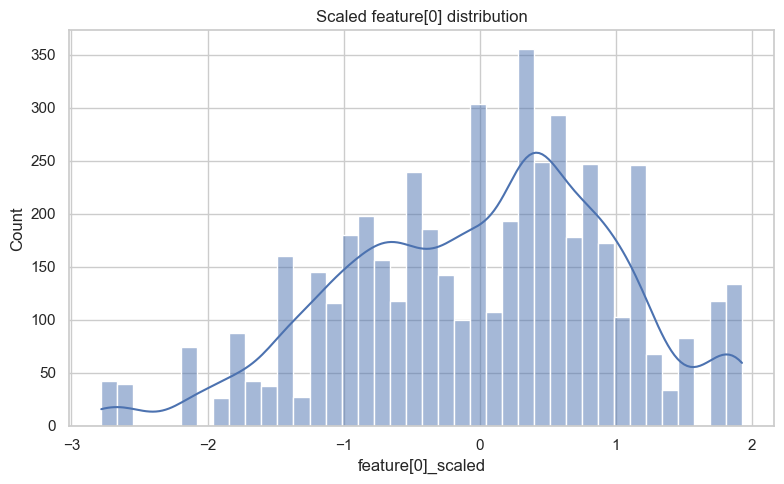

In [27]:
save_hist(
    X_train_scaled[:, 0],
    title="Scaled feature[0] distribution",
    xlabel="feature[0]_scaled",
    filename="viz_feature0_scaled.png",
    bins=40,
    kde=True
)

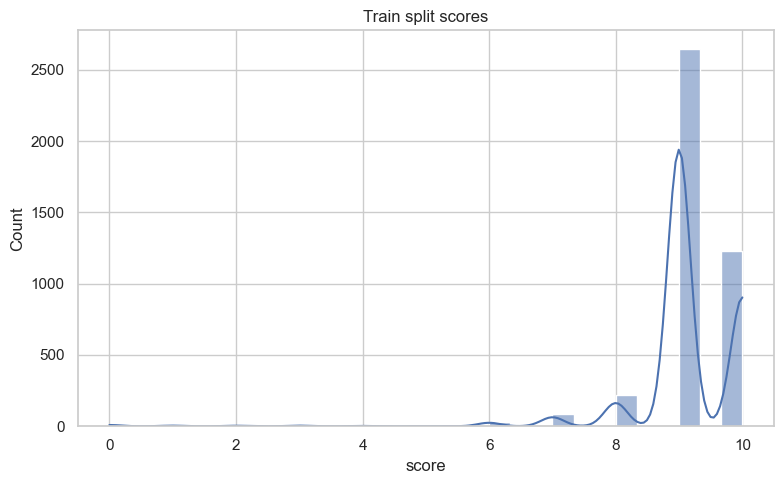

In [28]:
# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.15, random_state=42
)

save_hist(
    y_tr,
    title="Train split scores",
    xlabel="score",
    filename="viz_y_tr_hist.png",
    bins=30,
    kde=True
)

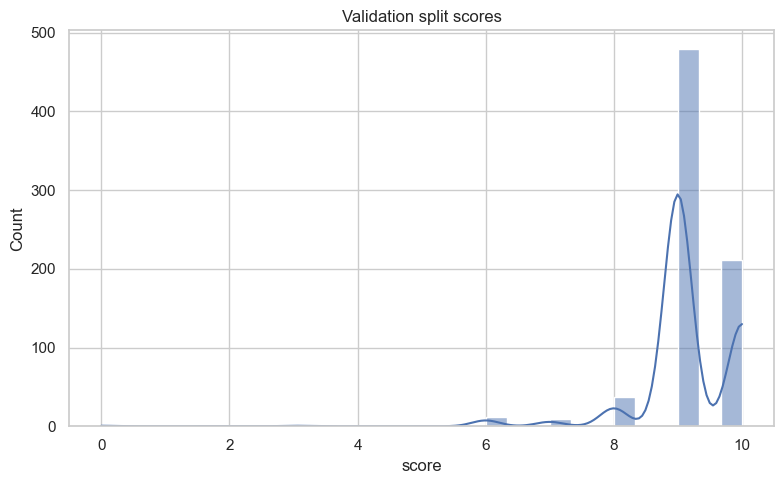

In [29]:
save_hist(
    y_val,
    title="Validation split scores",
    xlabel="score",
    filename="viz_y_val_hist.png",
    bins=30,
    kde=True
)


Training models...
Training CatBoost...
0:	learn: 0.9601948	test: 0.8108548	best: 0.8108548 (0)	total: 721ms	remaining: 30m 1s
100:	learn: 0.7828231	test: 0.7714068	best: 0.7710389 (81)	total: 32.9s	remaining: 13m
200:	learn: 0.6904577	test: 0.7675187	best: 0.7672056 (197)	total: 1m 5s	remaining: 12m 24s
300:	learn: 0.6250076	test: 0.7683489	best: 0.7667853 (224)	total: 1m 37s	remaining: 11m 52s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7667853128
bestIteration = 224

Shrink model to first 225 iterations.


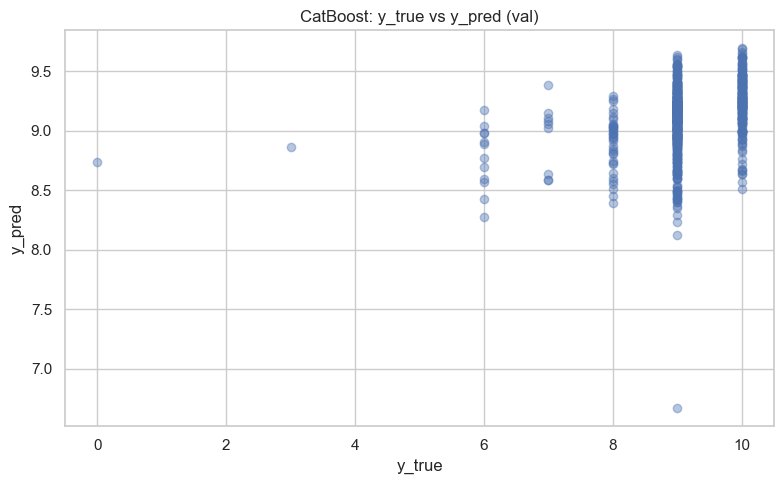

In [30]:
# ====================================================================
# STEP 5: Train 3 Models
# ====================================================================
print("\nTraining models...")

# Model 1: CatBoost
print("Training CatBoost...")
catboost_model = CatBoostRegressor(
    iterations=2500,
    learning_rate=0.025,
    depth=9,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=150
)

catboost_model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)

val_pred_catboost_tmp = catboost_model.predict(X_val)



In [31]:
print("\nTraining XGBoost...")
xgboost_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.025,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=3,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

xgboost_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=100
)
val_pred_xgb_tmp = xgboost_model.predict(X_val)


Training XGBoost...
[0]	validation_0-rmse:0.81042
[100]	validation_0-rmse:0.76944
[200]	validation_0-rmse:0.77785
[300]	validation_0-rmse:0.78403
[400]	validation_0-rmse:0.78856
[500]	validation_0-rmse:0.79097
[600]	validation_0-rmse:0.79222
[700]	validation_0-rmse:0.79324
[800]	validation_0-rmse:0.79400
[900]	validation_0-rmse:0.79457
[1000]	validation_0-rmse:0.79505
[1100]	validation_0-rmse:0.79521
[1200]	validation_0-rmse:0.79546
[1300]	validation_0-rmse:0.79556
[1400]	validation_0-rmse:0.79580
[1500]	validation_0-rmse:0.79590
[1600]	validation_0-rmse:0.79622
[1700]	validation_0-rmse:0.79619
[1800]	validation_0-rmse:0.79618
[1900]	validation_0-rmse:0.79634
[1999]	validation_0-rmse:0.79616


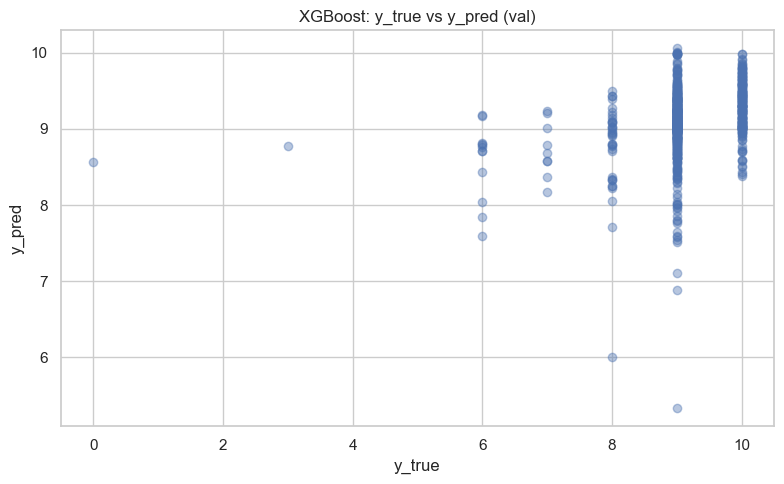

In [32]:
save_scatter(
    y_val,
    val_pred_xgb_tmp,
    title="XGBoost: y_true vs y_pred (val)",
    xlabel="y_true",
    ylabel="y_pred",
    filename="viz_xgb_val_scatter.png",
    alpha=0.4
)

In [33]:
# Model 3: LightGBM
print("\nTraining LightGBM...")
lgbm_model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.025,
    max_depth=9,
    num_leaves=120,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=3,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val)
)

val_pred_lgbm_tmp = lgbm_model.predict(X_val)


Training LightGBM...


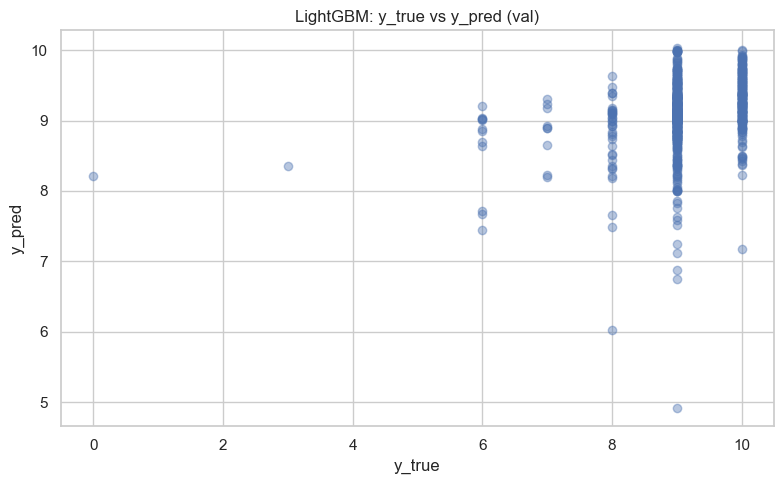

In [34]:
save_scatter(
    y_val,
    val_pred_lgbm_tmp,
    title="LightGBM: y_true vs y_pred (val)",
    xlabel="y_true",
    ylabel="y_pred",
    filename="viz_lgbm_val_scatter.png",
    alpha=0.4
)

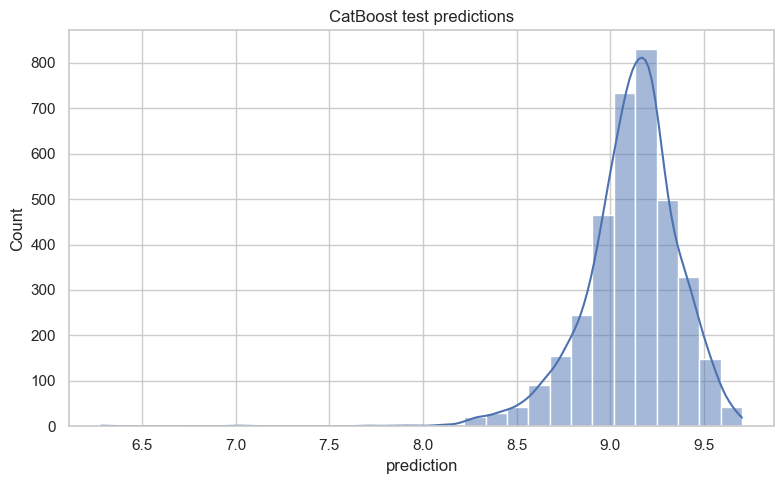

In [35]:
pred_catboost = catboost_model.predict(X_test_scaled)
pred_xgboost = xgboost_model.predict(X_test_scaled)
pred_lgbm = lgbm_model.predict(X_test_scaled)

# Visualize prediction distributions
save_hist(
    pred_catboost,
    title="CatBoost test predictions",
    xlabel="prediction",
    filename="viz_pred_catboost_test.png",
    bins=30,
    kde=True
)

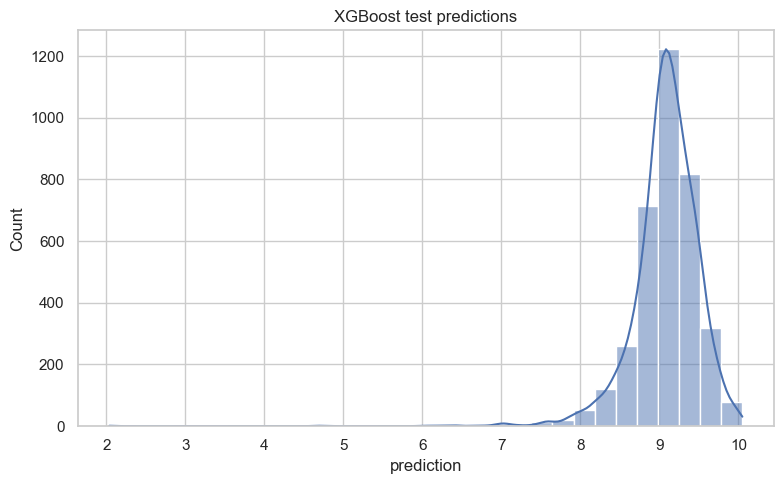

In [36]:
save_hist(
    pred_xgboost,
    title="XGBoost test predictions",
    xlabel="prediction",
    filename="viz_pred_xgb_test.png",
    bins=30,
    kde=True
)

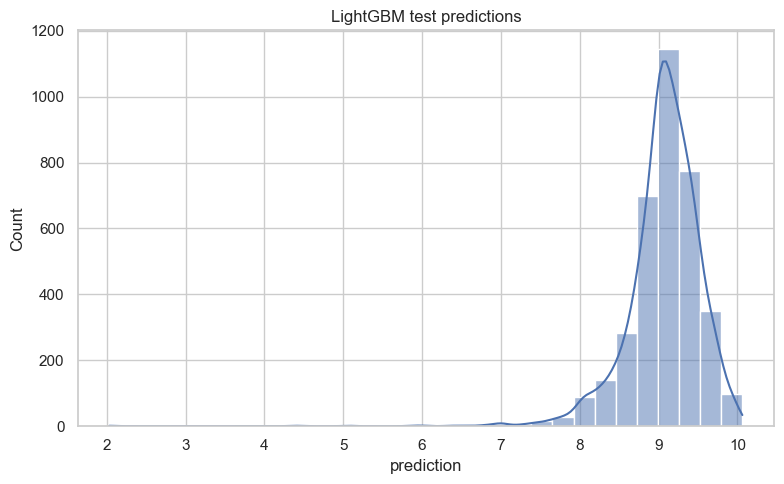

In [37]:
save_hist(
    pred_lgbm,
    title="LightGBM test predictions",
    xlabel="prediction",
    filename="viz_pred_lgbm_test.png",
    bins=30,
    kde=True
)


In [38]:
print("Training CatBoost Quantile (Q=0.4) for distribution shift...")
catboost_q40 = CatBoostRegressor(
    iterations=2500,
    learning_rate=0.025,
    depth=9,
    loss_function='Quantile:alpha=0.4',
    eval_metric='Quantile',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=150
)

catboost_q40.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)

pred_catboost_q40 = catboost_q40.predict(X_test_scaled)

Training CatBoost Quantile (Q=0.4) for distribution shift...
0:	learn: 0.2315026	test: 0.2114497	best: 0.2114497 (0)	total: 403ms	remaining: 16m 46s
50:	learn: 0.2179821	test: 0.2174558	best: 0.2112347 (1)	total: 16.4s	remaining: 13m 6s
100:	learn: 0.2049026	test: 0.2204526	best: 0.2112347 (1)	total: 32.4s	remaining: 12m 49s
150:	learn: 0.1930868	test: 0.2220982	best: 0.2112347 (1)	total: 48.5s	remaining: 12m 33s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.2112347065
bestIteration = 1

Shrink model to first 2 iterations.


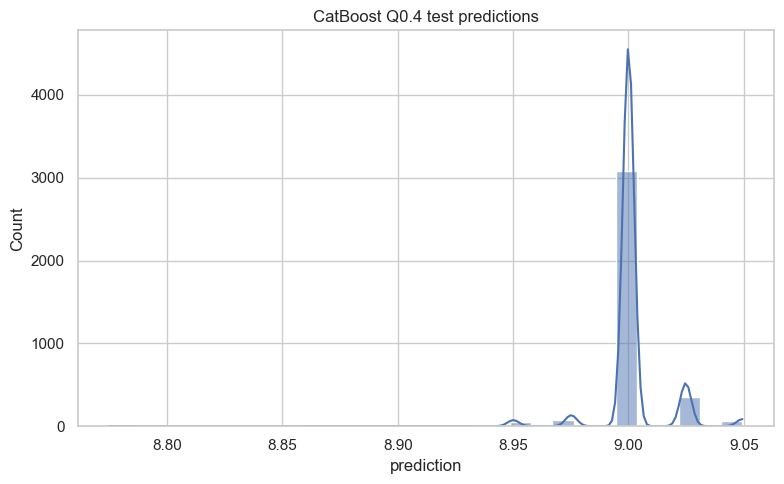

In [39]:
save_hist(
    pred_catboost_q40,
    title="CatBoost Q0.4 test predictions",
    xlabel="prediction",
    filename="viz_pred_catboost_q40_test.png",
    bins=30,
    kde=True
)

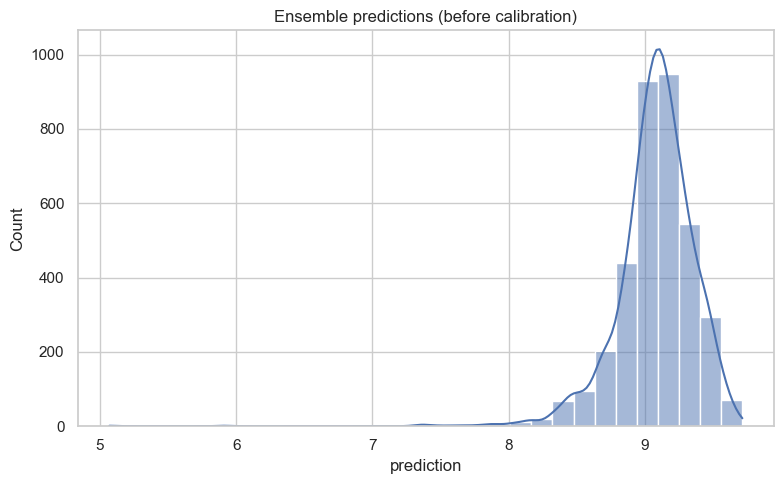

In [40]:
# Ensemble
pred_ensemble = (0.4 * pred_catboost +
                 0.25 * pred_xgboost +
                 0.2 * pred_lgbm +
                 0.15 * pred_catboost_q40)

pred_ensemble = np.clip(pred_ensemble, 0, 10)

save_hist(
    pred_ensemble,
    title="Ensemble predictions (before calibration)",
    xlabel="prediction",
    filename="viz_pred_ensemble_before_calib.png",
    bins=30,
    kde=True
)


Ensemble prediction statistics:
Mean: 9.08
Median: 9.10
Std: 0.29

Calibrating predictions...


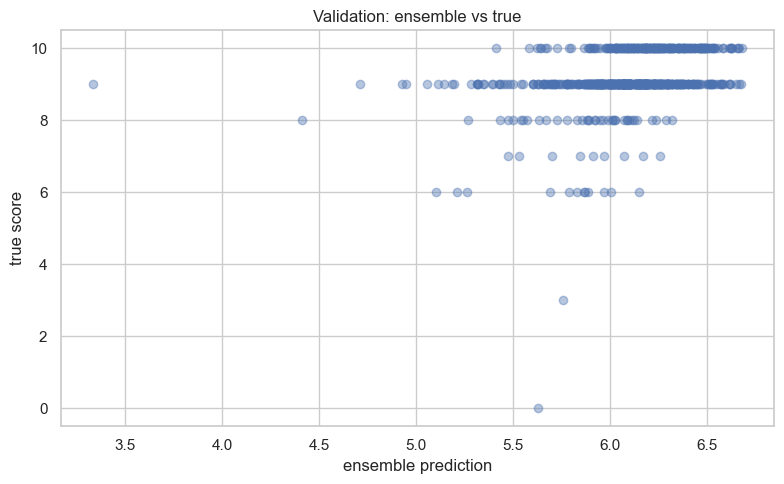

In [51]:
print(f"\nEnsemble prediction statistics:")
print(f"Mean: {pred_ensemble.mean():.2f}")
print(f"Median: {np.median(pred_ensemble):.2f}")
print(f"Std: {pred_ensemble.std():.2f}")

# ====================================================================
# STEP 7: Calibration
# ====================================================================
print("\nCalibrating predictions...")

val_pred_catboost = catboost_model.predict(X_val)
val_pred_xgboost = xgboost_model.predict(X_val)
val_pred_lgbm = lgbm_model.predict(X_val)
val_pred_catboost_q40 = catboost_q40.predict(X_val)

val_ensemble = (0.4 * val_pred_catboost +
                0.25 * val_pred_xgboost +
                0.2 * val_pred_lgbm +
                0.15 * val_pred_catboost_q40)

val_ensemble = np.clip(val_ensemble, 0, 10)

save_scatter(
    val_ensemble-np.sqrt(9),
    y_val,
    title="Validation: ensemble vs true",
    xlabel="ensemble prediction",
    ylabel="true score",
    filename="viz_val_ensemble_vs_true.png",
    alpha=0.4
)

In [52]:
iso_reg = IsotonicRegression(y_min=0, y_max=10, out_of_bounds='clip')
iso_reg.fit(val_ensemble, y_val)

pred_calibrated = iso_reg.predict(pred_ensemble)
pred_calibrated = np.clip(pred_calibrated, 0, 10)



Calibrated predictions:
Mean: 9.12
Median: 9.17
Std: 0.31

Applying distribution shift correction...
Current mean: 9.12, Target mean: 6.10
Shift amount: -3.02


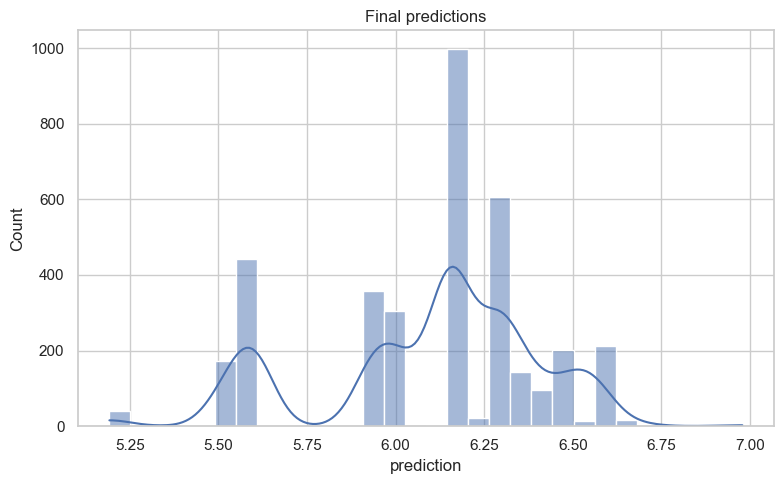

In [53]:
print(f"Calibrated predictions:")
print(f"Mean: {pred_calibrated.mean():.2f}")
print(f"Median: {np.median(pred_calibrated):.2f}")
print(f"Std: {pred_calibrated.std():.2f}")

# ====================================================================
# STEP 8: Post-processing for Distribution Shift
# ====================================================================
target_mean = 6.1
current_mean = pred_calibrated.mean()
shift_amount = target_mean - current_mean

print(f"\nApplying distribution shift correction...")
print(f"Current mean: {current_mean:.2f}, Target mean: {target_mean:.2f}")
print(f"Shift amount: {shift_amount:.2f}")

pred_final = pred_calibrated + shift_amount
pred_final = np.clip(pred_final, 0, 10)

save_hist(
    pred_final,
    title="Final predictions",
    xlabel="prediction",
    filename="viz_pred_final.png",
    bins=30,
    kde=True
)

In [54]:
print(f"\nFinal prediction statistics:")
print(f"Mean: {pred_final.mean():.2f}")
print(f"Median: {np.median(pred_final):.2f}")
print(f"Std: {pred_final.std():.2f}")
print(f"Min: {pred_final.min():.2f}, Max: {pred_final.max():.2f}")

# ====================================================================
# STEP 9: Create Submission File
# ====================================================================
print("\nCreating submission file...")

submission = pd.DataFrame({
    'ID': range(1, len(pred_final) + 1),
    'score': pred_final
})

submission.to_csv('submission_ult2.csv', index=False)
print("\nSubmission file saved as 'submission_ult2.csv'")
print(f"First 10 predictions:")
print(submission.head(10))
print("\nDone!")


Final prediction statistics:
Mean: 6.10
Median: 6.15
Std: 0.31
Min: 5.19, Max: 6.98

Creating submission file...

Submission file saved as 'submission_ult2.csv'
First 10 predictions:
   ID     score
0   1  6.292294
1   2  6.016887
2   3  6.016887
3   4  6.371282
4   5  5.938951
5   6  6.158753
6   7  6.149365
7   8  6.563331
8   9  6.016887
9  10  6.292294

Done!
